In [2]:
# 1. Setup and Library Downloads
import pandas as pd
import numpy as np
import re
import nltk # Core library for NLP
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# --- CRITICAL CORRECTION for NLTK Downloads ---
# This block ensures the necessary data is downloaded in the Colab environment
print("Downloading NLTK resources...")
try:
    nltk.download('stopwords', quiet=True)
    nltk.download('wordnet', quiet=True)
    print("NLTK downloads complete.")
except Exception as e:
    print(f"An error occurred during NLTK download: {e}")
# -----------------------------------------------

# Initialize Lemmatizer and Stopwords (must be done AFTER download)
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

print("\nLibraries and NLTK data successfully initialized.")

NLTK downloads complete.

Libraries and NLTK data successfully initialized.


In [3]:
# 2. Data Collection & Preparation

# Sample Resumes
RESUME_DATA = {
    'R1': "Senior Python Developer with 5 years experience. Expertise in Machine Learning, Pandas, Scikit-learn, and AWS cloud services. Strong background in NLP and deep learning models.",
    'R2': "Junior Front-End Developer. Highly skilled in JavaScript, React, HTML, and CSS. Built several responsive e-commerce platforms. Seeking entry-level web role.",
    'R3': "Data Analyst proficient in SQL, Tableau, and statistical analysis. Experience with large datasets and Python for data cleaning and visualization.",
    'R4': "Marketing Specialist with skills in SEO, SEM, content creation, and social media management. No technical coding background."
}

# Sample Job Descriptions
JOB_DATA = {
    'J1': "Senior Data Scientist position. Required: 5+ years with Python, NLP, and Machine Learning. AWS certification is a strong plus.",
    'J2': "Entry-Level Web Developer. Must be proficient in React, JavaScript, and CSS.",
    'J3': "SQL and Data Visualization Analyst. Expertise in Tableau and database querying required. Python experience is a bonus."
}

# Combine data into DataFrames
df_resumes = pd.DataFrame(list(RESUME_DATA.items()), columns=['ID', 'text'])
df_jobs = pd.DataFrame(list(JOB_DATA.items()), columns=['ID', 'text'])

print("--- Sample Data Generated ---")
print(f"Resumes: {list(RESUME_DATA.keys())}")
print(f"Jobs: {list(JOB_DATA.keys())}\n")

--- Sample Data Generated ---
Resumes: ['R1', 'R2', 'R3', 'R4']
Jobs: ['J1', 'J2', 'J3']



In [4]:
# 3. Text Preprocessing
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation, special characters, and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize, Remove stopwords, and Lemmatize
    tokens = text.split()
    cleaned_tokens = [
        lemmatizer.lemmatize(word) for word in tokens if word not in stop_words
    ]
    # Re-join the words
    return ' '.join(cleaned_tokens)

# Apply cleaning to both datasets
df_resumes['cleaned_text'] = df_resumes['text'].apply(clean_text)
df_jobs['cleaned_text'] = df_jobs['text'].apply(clean_text)

print("--- Text Preprocessing Complete ---")
# print(f"Example Cleaned Resume R1: {df_resumes.loc[0, 'cleaned_text'][:80]}...")

--- Text Preprocessing Complete ---


In [5]:
# 4. Feature Extraction (Vectorization) & Similarity Computation

# Combine all cleaned texts for consistent vector space
all_texts = df_resumes['cleaned_text'].tolist() + df_jobs['cleaned_text'].tolist()

# 4a. Use TF-IDF Vectorizer
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(all_texts)

# Separate the matrices
num_resumes = len(df_resumes)
resume_vectors = tfidf_matrix[:num_resumes]
job_vectors = tfidf_matrix[num_resumes:]

# 4b. Compute Cosine Similarity
similarity_matrix = cosine_similarity(resume_vectors, job_vectors)

# Convert to DataFrame for readability and analysis
similarity_df = pd.DataFrame(
    similarity_matrix,
    index=df_resumes['ID'],
    columns=df_jobs['ID']
)

print("\n--- TF-IDF Vectorization and Cosine Similarity Complete ---")
print("\n🔥 Similarity Score Matrix (Resumes vs. Jobs):\n")
print(similarity_df.round(4))


--- TF-IDF Vectorization and Cosine Similarity Complete ---

🔥 Similarity Score Matrix (Resumes vs. Jobs):

ID      J1      J2      J3
ID                        
R1  0.4619  0.0536  0.1361
R2  0.0000  0.4164  0.0000
R3  0.1277  0.0862  0.4726
R4  0.0000  0.0000  0.0000



🎯 Ranked Matches for Each Job Description:

➡️ Job J1: Senior Data Scientist position. Required: 5+ years with Python, NLP, and Machine Learning. AWS certification is a strong plus.
   1. R1 -> **46.19%** match
   2. R3 -> **12.77%** match

➡️ Job J2: Entry-Level Web Developer. Must be proficient in React, JavaScript, and CSS.
   1. R2 -> **41.64%** match
   2. R3 -> **8.62%** match

➡️ Job J3: SQL and Data Visualization Analyst. Expertise in Tableau and database querying required. Python experience is a bonus.
   1. R3 -> **47.26%** match
   2. R1 -> **13.61%** match


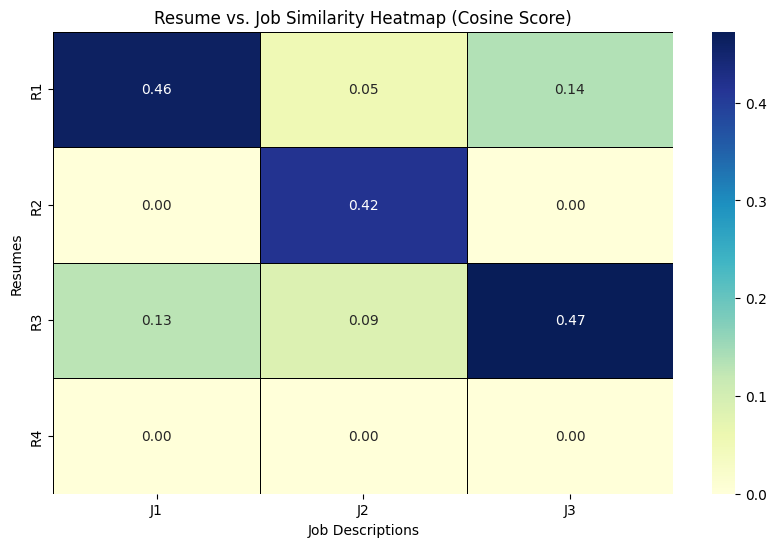

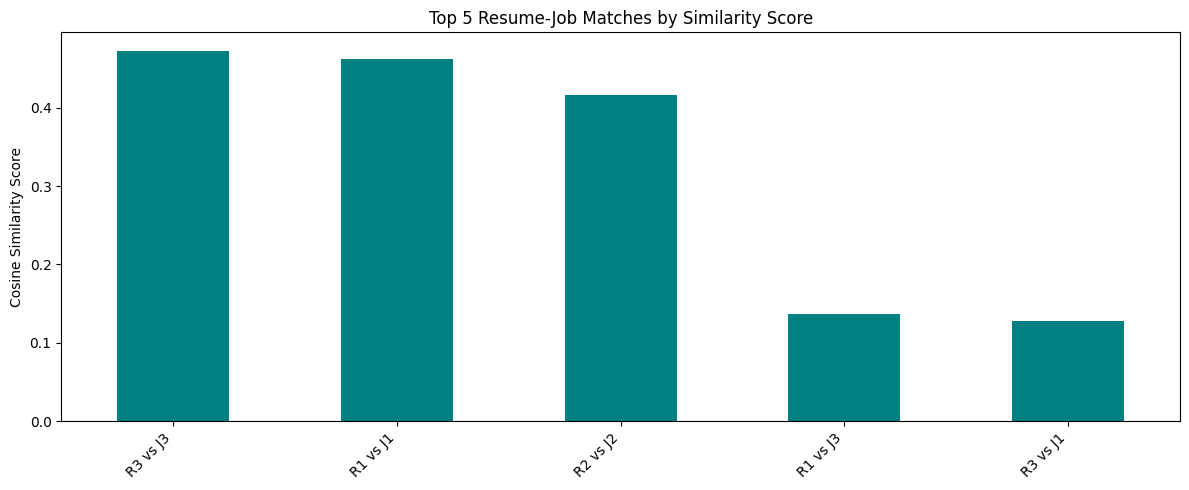

In [6]:
# 5. Results & Visualization

print("\n" + "="*50)
print("🎯 Ranked Matches for Each Job Description:")
print("="*50)

# Identify top N matching resumes for each job (N=2)
N = 2
ranked_matches = {}

for job_id in df_jobs['ID']:
    # Get the similarity scores for the current job, sorted descending
    job_scores = similarity_df[job_id].sort_values(ascending=False)

    print(f"\n➡️ Job {job_id}: {JOB_DATA[job_id]}")

    matches_list = []
    for rank, (resume_id, score) in enumerate(job_scores.head(N).items(), 1):
        matches_list.append((resume_id, score))
        print(f"   {rank}. {resume_id} -> **{score*100:.2f}%** match")

    ranked_matches[job_id] = matches_list

# Visualize similarity using a Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(similarity_df, annot=True, cmap='YlGnBu', fmt=".2f", linewidths=.5, linecolor='black')
plt.title('Resume vs. Job Similarity Heatmap (Cosine Score)')
plt.xlabel('Job Descriptions')
plt.ylabel('Resumes')
plt.show()

# Visualize similarity using a Bar Chart (Top 5 Matches overall)
plt.figure(figsize=(12, 5))
# Flatten the matrix and create a Series for all pairs
all_scores = similarity_df.stack().sort_values(ascending=False)
all_scores.index = [f'{idx[0]} vs {idx[1]}' for idx in all_scores.index]
all_scores.head(5).plot(kind='bar', color='teal')
plt.title('Top 5 Resume-Job Matches by Similarity Score')
plt.ylabel('Cosine Similarity Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [7]:
# 6. Documentation & Reporting

print("\n" + "#"*50)
print("## Documentation and Reporting")
print("#"*50)

print("\n### Preprocessing and Vectorization Steps:")
print("1. **Text Cleaning:** All text converted to **lowercase** to ensure consistency. Punctuation and numbers were removed.")
print("2. **Tokenization & Stopword Removal:** Text broken into words (tokens), and common, low-value words (e.g., 'the', 'is') were removed.")
print("3. **Lemmatization:** Words reduced to their base form (e.g., 'running' -> 'run', 'developers' -> 'developer') to group related skills.")
print("4. **Vectorization (TF-IDF):** The cleaned text was converted into numerical vectors using **Term Frequency-Inverse Document Frequency (TF-IDF)**. This weights words higher if they are important (frequent in a document, rare across the collection).")
print("5. **Similarity Calculation:** **Cosine Similarity** measured the angle between the Resume vector and the Job vector. A score closer to 1.0 indicates a high degree of shared vocabulary/skills.")

print("\n### Suggested Improvements (Higher Accuracy):")
print("1. **Semantic Matching (BERT/Sentence Transformers):** The current method relies on exact word overlap. Using **BERT embeddings** (or similar techniques) would allow the model to understand the *meaning* of the skills, e.g., matching 'Cloud Services' with 'AWS'.")
print("2. **Weighted Key Skills:** Assigning higher importance (higher weight) to words like 'Python' or 'NLP' compared to generic terms like 'strong' or 'experience'.")

print("\n### Discussed Limitations:")
print("1. **Ignores Context:** The 'Bag-of-Words' nature of TF-IDF treats words independently. It cannot distinguish between 'responsible for' and 'seeking to learn' a skill.")
print("2. **Skill Synonymy:** The model doesn't inherently know that 'Web Developer' and 'Front-End Engineer' are synonyms, which can lower the similarity score unfairly.")


##################################################
## Documentation and Reporting
##################################################

### Preprocessing and Vectorization Steps:
1. **Text Cleaning:** All text converted to **lowercase** to ensure consistency. Punctuation and numbers were removed.
2. **Tokenization & Stopword Removal:** Text broken into words (tokens), and common, low-value words (e.g., 'the', 'is') were removed.
3. **Lemmatization:** Words reduced to their base form (e.g., 'running' -> 'run', 'developers' -> 'developer') to group related skills.
4. **Vectorization (TF-IDF):** The cleaned text was converted into numerical vectors using **Term Frequency-Inverse Document Frequency (TF-IDF)**. This weights words higher if they are important (frequent in a document, rare across the collection).
5. **Similarity Calculation:** **Cosine Similarity** measured the angle between the Resume vector and the Job vector. A score closer to 1.0 indicates a high degree of shared vocabular